In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
# Technically not necessary in newest versions of jupyter
%matplotlib inline

In [2]:
from google.colab import drive

# Montez votre Google Drive
drive.mount('/content/drive')
my_data_dir ='/content/drive/MyDrive/cell_images'

Mounted at /content/drive


In [3]:
os.listdir(my_data_dir)

['train', 'test']

In [4]:
test_path = '/content/drive/MyDrive/cell_images/test/'
train_path = '/content/drive/MyDrive/cell_images/train/'

In [5]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [6]:
os.listdir('/content/drive/MyDrive/cell_images/train/parasitized')[0]

'C99P60ThinF_IMG_20150918_141001_cell_124.png'

In [7]:
para_cell ='/content/drive/MyDrive/cell_images/train/parasitized/C99P60ThinF_IMG_20150918_141001_cell_124.png'

In [8]:
para_img=imread(para_cell)

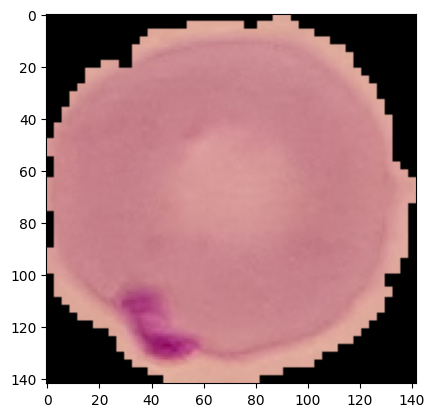

In [9]:
plt.imshow(para_img)

In [10]:
para_img.shape

(142, 142, 3)

In [11]:
os.listdir('/content/drive/MyDrive/cell_images/train/uninfected')[0]

'C61P22N_ThinF_IMG_20150818_112518_cell_11.png'

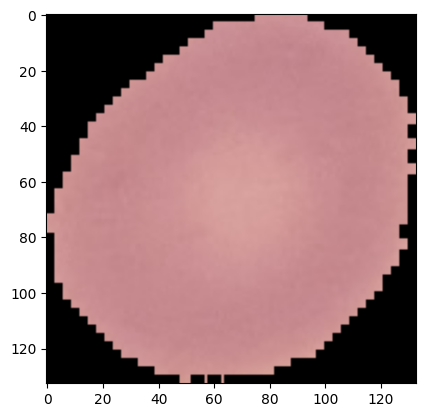

In [12]:
unifected_cell_path = '/content/drive/MyDrive/cell_images/train/uninfected/C61P22N_ThinF_IMG_20150818_112518_cell_11.png'
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell)

In [13]:
len(os.listdir('/content/drive/MyDrive/cell_images/train/parasitized'))

12480

In [14]:
len(os.listdir('/content/drive/MyDrive/cell_images/train/uninfected'))

10424

In [15]:
unifected_cell.shape

(133, 133, 3)

In [16]:
para_img.shape

(142, 142, 3)

In [17]:
# Other options: https://stackoverflow.com/questions/1507084/how-to-check-dimensions-of-all-images-in-a-directory-using-python
dim1 = []
dim2 = []
for image_filename in os.listdir('/content/drive/MyDrive/cell_images/test/uninfected'):
    img = imread('/content/drive/MyDrive/cell_images/test/uninfected'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

In [20]:
np.mean(dim1)

130.85648854961832

In [21]:
np.mean(dim2)

130.73282442748092

In [22]:
image_shape = (130,130,3)

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [25]:
image_gen.flow_from_directory(train_path)

Found 22902 images belonging to 2 classes.


In [26]:
image_gen.flow_from_directory(test_path)

Found 2610 images belonging to 2 classes.


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [28]:
#https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary so we use sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [32]:
batch_size = 16
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 22902 images belonging to 2 classes.
Found 2610 images belonging to 2 classes.


In [33]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [34]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
results = model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

NameError: name 'model' is not defined

In [ ]:
from tensorflow.keras.models import load_model
model.save('malaria_detector.h5')